In [1]:

import os
from google.colab import drive

drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive/detection'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/detection


In [2]:
%cd Face-Mask-Detection/

/content/gdrive/My Drive/detection/Face-Mask-Detection


In [3]:
!ls

dataset		      mask_detector.model  train_mask_detector.py
detect_mask_video.py  plot.png
face_detector	      requirements.txt


In [4]:
%cd dataset

/content/gdrive/My Drive/detection/Face-Mask-Detection/dataset


In [5]:
!ls

test  train


In [6]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input

In [7]:
##Setting the size and image path
IMAGE_SIZE = [224, 224]

train_path = 'train'
valid_path = 'test'

In [8]:
##not including the fully connected layers and setting the image size to 227*227 and not training all the layers since we are using transfer learning(keep the weights as same)
mobilenet = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in mobilenet.layers:
    layer.trainable = False

In [9]:
model= mobilenet.output
model = AveragePooling2D(pool_size=(7, 7))(model)
model = Flatten(name="flatten")(model)
model = Dense(128, activation="relu")(model)
model = Dropout(0.5)(model)
model = Dense(2, activation="softmax")(model)

In [10]:
model = Model(inputs=mobilenet.input, outputs=model)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [12]:
##Compiling the model 
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [14]:
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 3633 images belonging to 2 classes.


In [15]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 199 images belonging to 2 classes.


In [16]:
final = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=6,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
 19/114 [====>.........................] - ETA: 12:04 - loss: 0.5353 - accuracy: 0.7260

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


114/114 [==============================] - 890s 8s/step - loss: 0.2244 - accuracy: 0.8967 - val_loss: 0.0502 - val_accuracy: 0.9749
Epoch 2/20
114/114 [==============================] - 170s 1s/step - loss: 0.0505 - accuracy: 0.9809 - val_loss: 0.1129 - val_accuracy: 0.9497
Epoch 3/20
114/114 [==============================] - 169s 1s/step - loss: 0.0303 - accuracy: 0.9917 - val_loss: 0.0527 - val_accuracy: 0.9749
Epoch 4/20
114/114 [==============================] - 170s 1s/step - loss: 0.0261 - accuracy: 0.9915 - val_loss: 0.0798 - val_accuracy: 0.9598
Epoch 5/20
114/114 [==============================] - 170s 1s/step - loss: 0.0342 - accuracy: 0.9882 - val_loss: 0.0324 - val_accuracy: 0.9799
Epoch 6/20
114/114 [==============================] - 167s 1s/step - loss: 0.0243 - accuracy: 0.9910 - val_loss: 0.0204 - val_accuracy: 0.9950
Epoch 7/20
114/114 [==============================] - 171s 1s/step - loss: 0.0144 - accuracy: 0.9959 - val_loss: 0.0383 - val_accuracy: 0.9849
Epoch 8/20

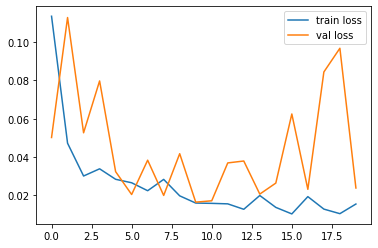

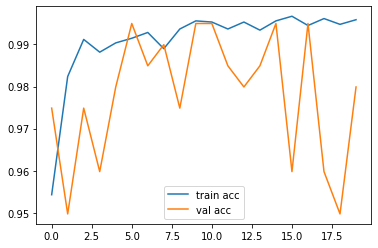

<Figure size 432x288 with 0 Axes>

In [17]:
# plot the loss
plt.plot(final.history['loss'], label='train loss')
plt.plot(final.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(final.history['accuracy'], label='train acc')
plt.plot(final.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [18]:
from tensorflow.keras.models import load_model

model.save('mobilenet.h5')

In [19]:
y_pred = model.predict(test_set)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [20]:
##Taking the maximum value amongst the two
y_pred_val = np.argmax(y_pred, axis=1)

In [21]:
y_pred_val

array([1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0])

Go and wear a Mask


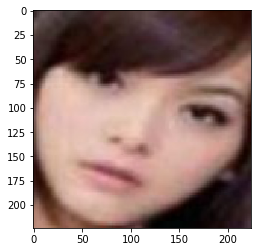

In [22]:
img = image.load_img("test/without_mask/0_0_wangruoyi_0017.jpg",target_size=(224,224)) ##loading the image
img = np.asarray(img) ##converting to an array
img = img / 255 ##scaling by doing a division of 255
plt.imshow(img)
img = np.expand_dims(img, axis=0) ##expanding the dimensions
from keras.models import load_model
saved_model = load_model("mobilenet.h5") ##loading the model
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("Person has Mask")
else:
    print('Go and wear a Mask')

Person has Mask


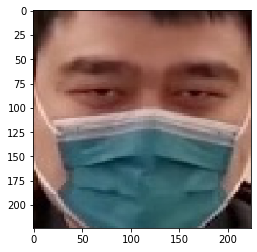

In [23]:
img = image.load_img("test/mask/0_0_3 copy 12.jpg",target_size=(224,224)) ##loading the image
img = np.asarray(img) ##converting to an array
img = img / 255 ##scaling by doing a division of 255
plt.imshow(img)
img = np.expand_dims(img, axis=0) ##expanding the dimensions
from keras.models import load_model
saved_model = load_model("mobilenet.h5") ##loading the model
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("Person has Mask")
else:
    print('Go and wear a Mask')